<a href="https://colab.research.google.com/github/WilliamAshbee/DataminingAssignments/blob/main/DM_A3_Ashbee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np


In [2]:
#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod'
#df1 = pd.read_csv(url,header=None,skiprows=(i for i in range(20)),delim_whitespace=True,error_bad_lines=False)

##no longer using cleve mod since Dr. Zhang mentioned it was acceptable to use processed.cleveland.data


In [3]:
""" obsolete code for processing clevemod
pain = {'angina': 1, 'asympt': 4,'notang':2,'abnang':3}
gender = {'male':1,'fem':0}
bsl20 = {'true':1,'fal':0}
restingecg = {'norm':0,'abn':1, 'hyp':2}
exindang = {'true':1,'fal':0}
slope = {'up':1, 'flat':2, 'down':3}
thal = {'norm':1, 'fix':2, 'rev':3}
state= {'buff':1,'sick':-1}
code = {'H':0,'S1':1,'S2':2,'S3':3,'S4':4}
eleventh = {'?':-10000}
twelth = {'?':-10000}
#df2 = df1.replace({1: gender,2:pain,5:bsl20,6:restingecg,8:exindang,10:slope,11:eleventh,12:{**thal, **twelth},13:state,14:code})
"""

" obsolete code for processing clevemod\npain = {'angina': 1, 'asympt': 4,'notang':2,'abnang':3}\ngender = {'male':1,'fem':0}\nbsl20 = {'true':1,'fal':0}\nrestingecg = {'norm':0,'abn':1, 'hyp':2}\nexindang = {'true':1,'fal':0}\nslope = {'up':1, 'flat':2, 'down':3}\nthal = {'norm':1, 'fix':2, 'rev':3}\nstate= {'buff':1,'sick':-1}\ncode = {'H':0,'S1':1,'S2':2,'S3':3,'S4':4}\neleventh = {'?':-10000}\ntwelth = {'?':-10000}\n#df2 = df1.replace({1: gender,2:pain,5:bsl20,6:restingecg,8:exindang,10:slope,11:eleventh,12:{**thal, **twelth},13:state,14:code})\n"

Links that helped in my solution

https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
\
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html

In [4]:
url2 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df_clev = pd.read_csv(url2,header=None,error_bad_lines=False)

In [5]:
questionmark = {'?':'-10000'}

dfcn = df_clev
dfcn = dfcn.replace({11:questionmark,12:questionmark})
dfcn = dfcn.to_numpy().astype(float)

print(np.sum(dfcn=='?'))#,np.sum(df2n=='?'))

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [6]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import os
y = dfcn[:,13]

X = dfcn[:,:13]

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.fit_transform(X)



Another link that led to my solutions \
https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
\
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
\
https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659

In [7]:
#note multiclass roc curve is a little poorly defined, so i went with
#solution from: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
#runtime on google colab was about 4 minutes
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score


cv = StratifiedKFold(n_splits=10)
y = y.squeeze()

#code multiclass_roc_auc_score from medium article above and below
#https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

import random
def getMonteCarloSearchParams():#random search is faster than grid search for most purposes
  C = random.choice(np.logspace(-6, -1, 10).tolist())
  gamma = random.choice([0.001, 0.01, 0.1, 1])
  k = random.choice([3,4,5,6,7])
  d = random.choice([3,4,5,6,7])
  maxit = random.choice([10**3,10**4,10**5,10**6])

  return C,gamma,k,d,maxit

epochs = 10

scores = np.zeros((epochs,10))
aucs = np.zeros((epochs,10))
f1_scores = np.zeros((epochs,10))

params = np.zeros((epochs,5))


for e in range(epochs):
  C,gamma,k,d,maxit = getMonteCarloSearchParams()
  params[e,0] = C
  params[e,1] = gamma
  params[e,2] = k
  params[e,3] = d
  params[e,4] = maxit
  
  print('\nc',C,'gamma',gamma,'k',k,'d',d,'maxit',maxit)
  rfc = RandomForestClassifier(max_depth=d)
  knnc = KNeighborsClassifier(n_neighbors=k)
  bagging_knnc = BaggingClassifier(knnc, max_samples=0.4, max_features=4)
  lrc = LogisticRegression(max_iter = maxit, solver='lbfgs', multi_class='auto')
  svc = svm.SVC(kernel = 'rbf',gamma = gamma,max_iter = maxit,C= C,decision_function_shape='ovo', probability=True)
  adac = AdaBoostClassifier(base_estimator=svc)
  vc = VotingClassifier(estimators=[("logistic regression",lrc),('Random Forests', rfc), ('KNeighbors', bagging_knnc), ('adaSVCrbf', adac)], voting='hard')
  classifier = vc
  
  
  for i, (train, test) in enumerate(cv.split(X, y)):
    print('\nepoch',e,' cv of 10:',i+1)
    classifier.fit(X[train], y[train])
    y_pred = classifier.predict(X[test])

    scores[e,i] = classifier.score(X[test],y[test])
    aucs[e,i] = multiclass_roc_auc_score(y[test],y_pred)
    f1_scores[e,i] = f1_score(y[test], y_pred, average='macro')
    print("score",'{:.2f}'.format(scores[e,i]))
    print('auc score','{:.2f}'.format(aucs[e,i]))
    print('f1 score', '{:.2f}'.format(f1_scores[e,i]))




c 0.0005994842503189409 gamma 0.001 k 6 d 3 maxit 100000

epoch 0  cv of 10: 1
score 0.61
auc score 0.57
f1 score 0.28

epoch 0  cv of 10: 2
score 0.55
auc score 0.50
f1 score 0.14

epoch 0  cv of 10: 3
score 0.55
auc score 0.51
f1 score 0.15

epoch 0  cv of 10: 4
score 0.57
auc score 0.50
f1 score 0.14

epoch 0  cv of 10: 5
score 0.60
auc score 0.58
f1 score 0.32

epoch 0  cv of 10: 6
score 0.53
auc score 0.50
f1 score 0.14

epoch 0  cv of 10: 7
score 0.57
auc score 0.54
f1 score 0.21

epoch 0  cv of 10: 8
score 0.53
auc score 0.51
f1 score 0.15

epoch 0  cv of 10: 9
score 0.53
auc score 0.50
f1 score 0.14

epoch 0  cv of 10: 10
score 0.53
auc score 0.50
f1 score 0.14

c 1.2915496650148827e-05 gamma 0.1 k 5 d 4 maxit 10000

epoch 1  cv of 10: 1
score 0.61
auc score 0.57
f1 score 0.27

epoch 1  cv of 10: 2
score 0.58
auc score 0.55
f1 score 0.22

epoch 1  cv of 10: 3
score 0.55
auc score 0.51
f1 score 0.15

epoch 1  cv of 10: 4
score 0.63
auc score 0.57
f1 score 0.30

epoch 1  cv of 1

In [8]:
#"C,gamma,k,d,maxit"
sc_par = params[np.argmax(np.mean(scores,axis=1)),:]
auc_par = params[np.argmax(np.mean(aucs,axis=1)),:]
f1_par = params[np.argmax(np.mean(f1_scores,axis=1)),:]

 

print('best average scores cross validation value:',"{:.2f}".format(np.max(np.mean(scores,axis =1 ))))
print('model params C,gamma,k,d,maxit:','{:e} {:6g} {:d} {:d} {:d} '.format(sc_par[0],sc_par[1],(int)(sc_par[2]),(int)(sc_par[3]),(int)(sc_par[4])))

print('\nbest average auc value:',"{:.2f}".format(np.max(np.mean(aucs,axis =1 ))))
print('model params C,gamma,k,d,maxit:','{:e} {:6g} {:d} {:d} {:d} '.format(auc_par[0],auc_par[1],(int)(auc_par[2]),(int)(auc_par[3]),(int)(auc_par[4])))

print('\nbest average f1score value:',"{:.2f}".format(np.max(np.mean(f1_scores,axis =1 ))))
print('model params C,gamma,k,d,maxit:','{:e} {:6g} {:d} {:d} {:d} '.format(f1_par[0],f1_par[1],(int)(f1_par[2]),(int)(f1_par[3]),(int)(f1_par[4])))


best average scores cross validation value: 0.58
model params C,gamma,k,d,maxit: 5.994843e-04   0.01 5 5 1000000 

best average auc value: 0.55
model params C,gamma,k,d,maxit: 5.994843e-04   0.01 5 5 1000000 

best average f1score value: 0.24
model params C,gamma,k,d,maxit: 5.994843e-04   0.01 5 5 1000000 


In [9]:
#https://www.kaggle.com/iamhungundji/covid19-symptoms-checker
#bonus work dataset: predict severity
#see bonus ipython notebook

#Begin bonus section

For the bonus, I attempted supervised learning on this dataset, but the classifiers didn't predict severity better than random, so I chose to do clustering instead. I didn't see too many csv datasets useful for simple classification.



dataset https://www.kaggle.com/iamhungundji/covid19-symptoms-checker 


bonus work dataset: predict severity
\
https://github.com/WilliamAshbee/DataminingAssignments/blob/main/covid-cleaned-data.csv



In [10]:
import pandas as pd
url = 'https://raw.githubusercontent.com/WilliamAshbee/DataminingAssignments/main/covid-cleaned-data.csv'
df_cov = pd.read_csv(url,error_bad_lines=False)

In [11]:
df_cov.shape


(316800, 27)

In [12]:
columns = ['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing',
       'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion',
       'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19',
       'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male',
       'Gender_Transgender', 'Severity_Mild', 'Severity_Moderate',
       'Severity_None', 'Severity_Severe', 'Contact_Dont-Know', 'Contact_No',
       'Contact_Yes', 'Country']
cmap = dict()
for i in range(len(columns)):
  cmap[columns[i]] = i 

yfcols = [ 'Severity_Severe']

yfinds = [cmap[col] for col in yfcols]

ycols = [  'Severity_Mild', 'Severity_Moderate',
       'Severity_None', 'Severity_Severe']

yinds = [cmap[col] for col in ycols]


print(yinds,yfinds)


[19, 20, 21, 22] [22]


In [13]:
df_nump = df_cov.to_numpy()


In [14]:
xind = []
for i in range(len(columns)-1):
  if i not in yinds:
    xind.append(i)
print(xind)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25]


I removed some columns from X I deemed Y values. These values weren't useful for classification. I tried.

In [15]:
import numpy as np
X = df_nump[:,xind].astype(float)
print(X)
np.random.seed(seed=0)
args = np.random.choice(X.shape[0], (int)(X.shape[0]/20.0))
X = X[args]


[[1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


One method for determining number of clusters I found here: \\
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb






In [16]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      for j in range(points.shape[1]):
        curr_sse += (points[i, j] - curr_center[j]) ** 2 
      
    sse.append(curr_sse)
  return sse


In [17]:
wss_list = calculate_WSS(X,4)


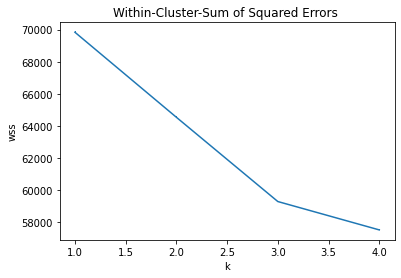

In [18]:
import matplotlib.pyplot as plt
xs = [i for i in range(1,5)]

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('wss')
ax1.set_xlabel('k')
ax1.set_title('Within-Cluster-Sum of Squared Errors ')

plt.plot(xs,wss_list,',-')


Within this dataset, it is likely that there are 3 clusters of patients. If this dataset is clean relating to patients, then I would guess the clusters relate to either severity or disease type. Calculating the within cluster sum yields the above graph.



For n_clusters = 2 The average silhouette_score is : 0.07732865275510019
For n_clusters = 3 The average silhouette_score is : 0.11505304403096857
For n_clusters = 4 The average silhouette_score is : 0.0848151435898072


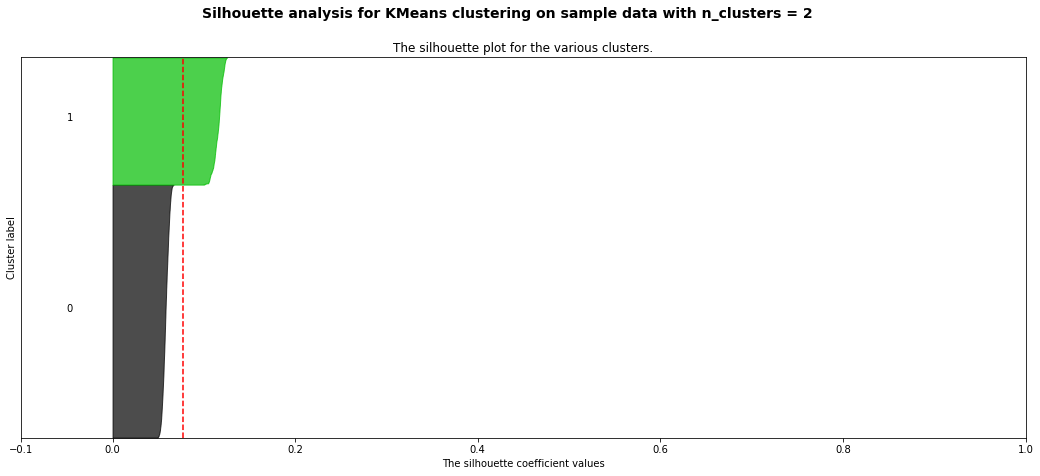

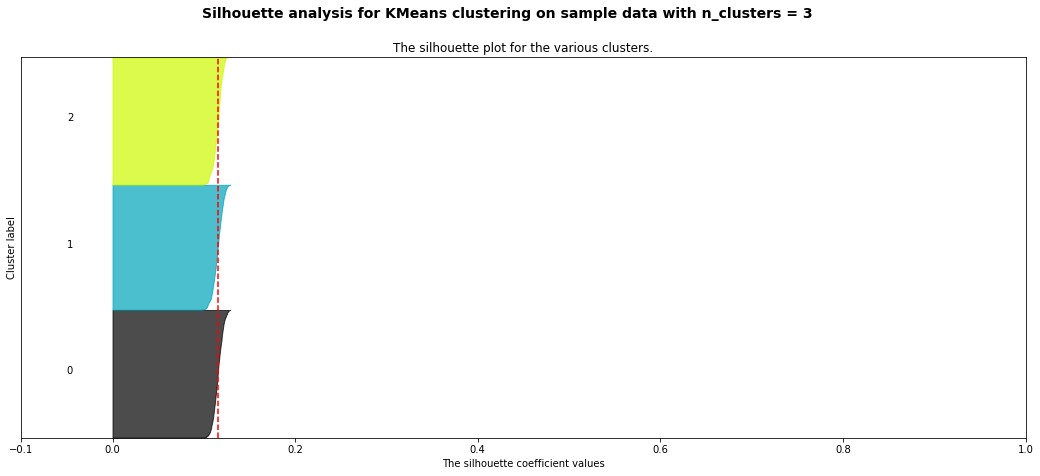

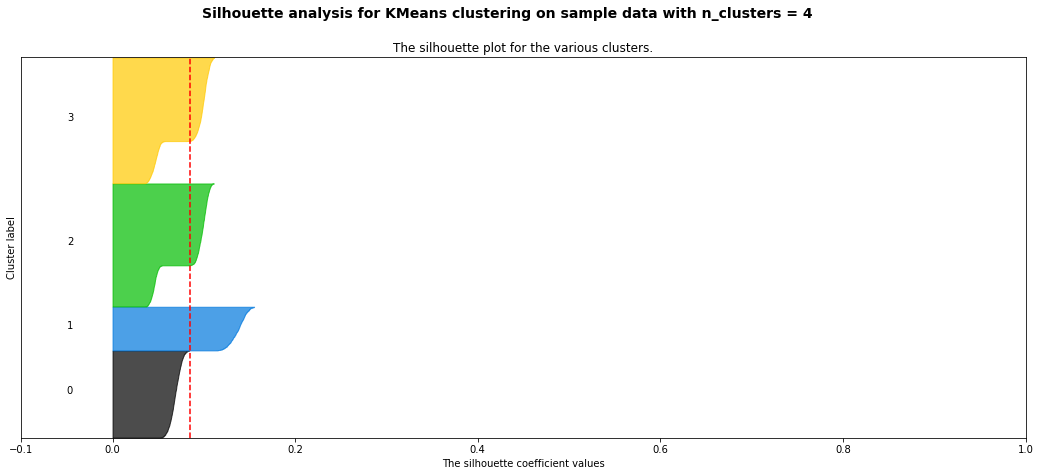

In [19]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range(2,5):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    
    
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


Visual inspection of K means clustering and silhouette analysis shows that the number of clusters is 3 here as well most likely due to fewest below average clusters being associated with 3 clusters and a highest average silhouette score.



I borrowed analysis from 
\
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py



For n_clusters = 2 The average silhouette_score is : 0.056955815608686025
For n_clusters = 3 The average silhouette_score is : 0.05957010127398947
For n_clusters = 4 The average silhouette_score is : 0.062596477684106
For n_clusters = 5 The average silhouette_score is : 0.0735949566223512
For n_clusters = 6 The average silhouette_score is : 0.07960297010409446


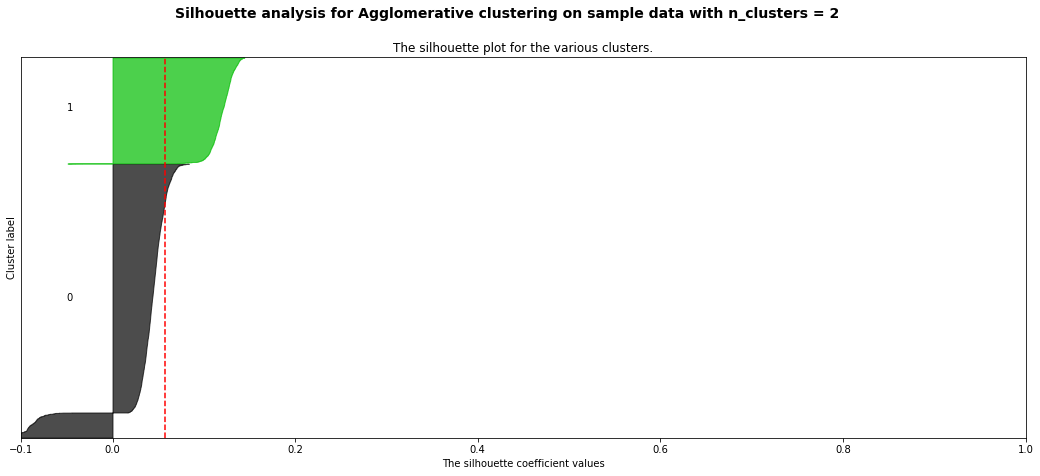

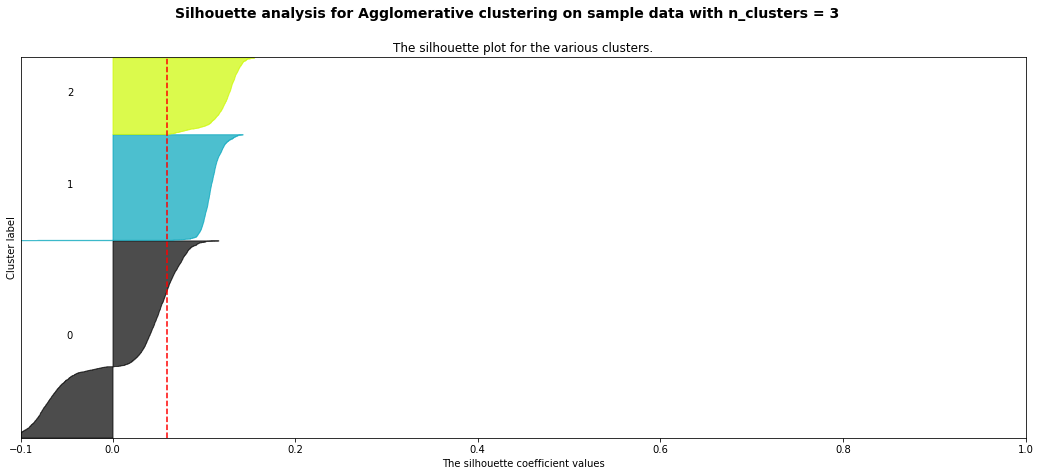

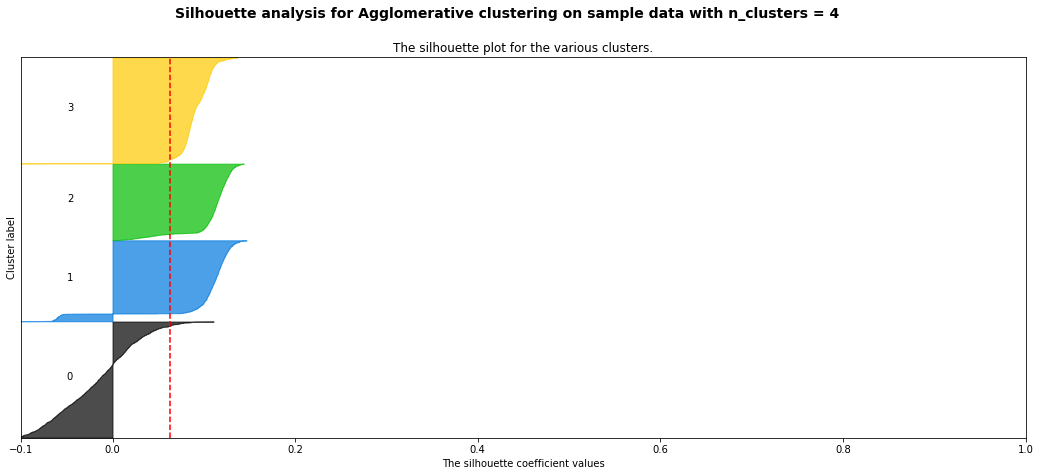

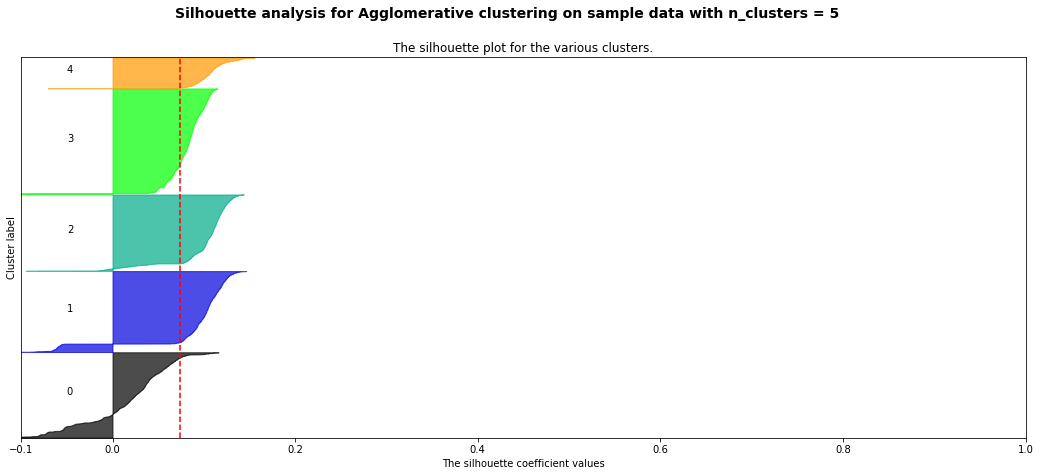

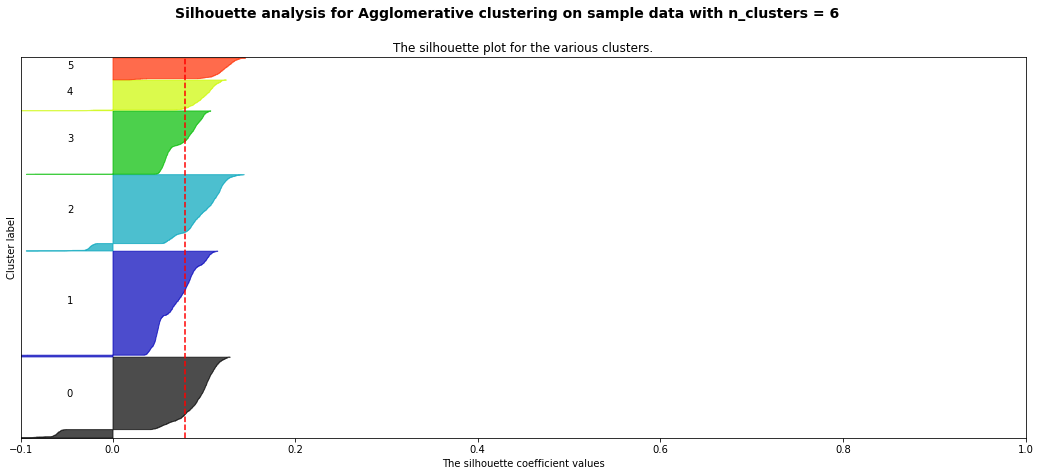

In [20]:
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering


for n_clusters in range(2,7):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


Overall, I would say that the silhouette score was not particularly strong in either kmeans or agglomerative clustering, but within agglomerative clustering there always is substantial data under the average in agglomerative clustering. My inference is that this dataset is not particularly useful for either clustering (shown) or classification of symptom severity (not shown, but no predictions were better than random on any classifier, thus that analysis was discarded in favor of clustering)

